In [ ]:
from google.colab import files

In [ ]:
# Install Kaggle library
!pip install -q kaggle
!mkdir -p ~/.kaggle
# Upload Kaggle API key file (might have to rerun to work)
files.upload()

# Download the dataset
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip it
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

# Set image size and paths
IMG_SIZE = (224, 224)
base_skin_dir = "/content/"  # Change this to your dataset's base path
df_meta = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Map images with paths and classes
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))
}

# Update lesion types to exclude 'nv' (Melanocytic nevi)
lesion_type_dict = {
    'mel': 'Melanoma', 'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma', 'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions', 'df': 'Dermatofibroma'
}

# Filter out 'nv' class and update dataframe
df_meta = df_meta[df_meta['dx'] != 'nv']
df_meta['path'] = df_meta['image_id'].map(imageid_path_dict.get)
df_meta['cell_type'] = df_meta['dx'].map(lesion_type_dict.get)
df_meta['cell_type_idx'] = pd.Categorical(df_meta['cell_type']).codes

# Load and preprocess images
def load_and_preprocess_image(path):
    img = load_img(path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img

X = np.array([load_and_preprocess_image(path) for path in df_meta['path']])
y = df_meta['cell_type_idx'].values

classes = ['df', 'vasc', 'akiec']
df_filtered = df[df['dx'].isin(classes)]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Model checkpoint path
checkpoint_path = "densenet169_skin_cancer_checkpoint.h5"

# Check if a checkpoint exists; if not, load a fresh DenseNet model
if os.path.exists(checkpoint_path):
    print("Loading model from previous checkpoint...")
    model = load_model(checkpoint_path)
else:
    print("No checkpoint found, loading a fresh DenseNet169 model...")
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last 30 layers for fine-tuning
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Build the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(lesion_type_dict), activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

# Define callbacks for model checkpointing and learning rate reduction
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,  # Allow for early stopping to intervene if needed
    callbacks=[checkpoint, reduce_lr]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")




<ipython-input-5-f42e9206b2dd>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta['path'] = df_meta['image_id'].map(imageid_path_dict.get)
<ipython-input-5-f42e9206b2dd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta['cell_type'] = df_meta['dx'].map(lesion_type_dict.get)
<ipython-input-5-f42e9206b2dd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Loading model from previous checkpoint...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 256)               20873472  
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 98s 1s/step - loss: 1.3243 - accuracy: 0.5661 - val_loss: 1.1568 - val_accuracy: 0.6118 - lr: 1.0000e-04
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 1.1097 - accuracy: 0.6382
Epoch 2: val_loss improved from 1.15676 to 1.13286, saving model to densenet169_skin_cancer_checkpoint.h5
83/83 [==============================] - 84s 1s/step - loss: 1.1097 - accuracy: 0.6382 - val_loss: 1.1329 - val_accuracy: 0.6193 - lr: 1.0000e-04
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 1.0021 - accuracy: 0.6699
Epoch 3: val_loss improved from 1.13286 to 1.00457, saving model to densenet169_skin_cancer_checkpoint.h5
83/83 [==============================] - 81s 975ms/step - loss: 1.0021 - accuracy: 0.6699 - val_loss: 1.0046 - val_accuracy: 0.6752 - lr: 1.0000e-04
Epoch 4/100
83/83 [==============================] - ETA: 0s - loss: 0.8932 - accuracy: 0.6979
Epoch 4: val_loss did not improve from 1.00457
83/83 [========

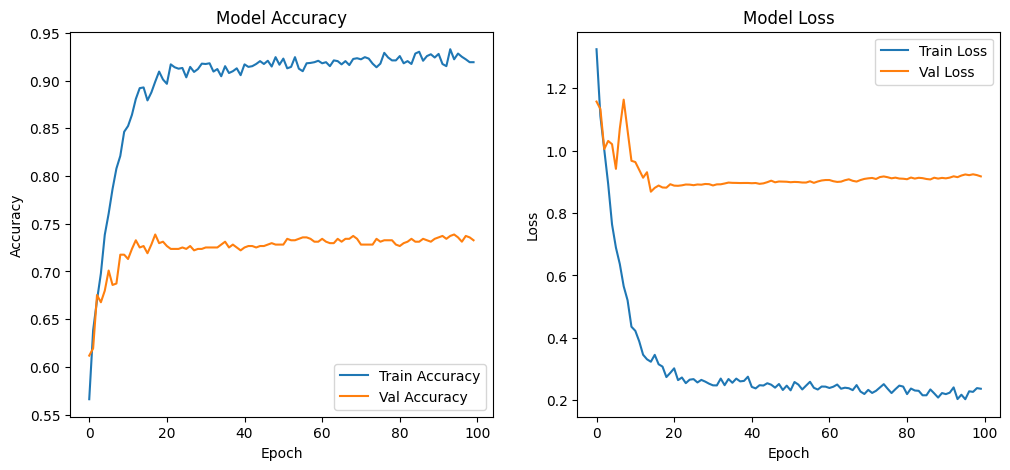

In [ ]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()